Notebook to compare the execution time of the different 
metrics to use in covariance matrix estimation

In [1]:
from src.data_preparation.data_preparation import read_eeg_file
from scipy import signal
import pyriemann.utils.mean as rie_mean
import numpy as np
import time
import matplotlib.pyplot as plt

/home/mauricio/development/environments/anaconda3/envs/motor-imagery/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Load some EEG data

In [2]:
FS = 100
TIME_LENGTH = int(FS * 2.5)
TIME_WINDOW = int(FS * 2.5)
DATA_FOLDER = "data/si-bci/bci-iii-dataset-iv-a"
CSP_COMPONENTS = 8

subject = 1
left_data_file = f"{DATA_FOLDER}/left-hand-subject-{subject}.csv"
right_data_file = f"{DATA_FOLDER}/right-hand-subject-{subject}.csv"
data = read_eeg_file(left_data_file, right_data_file, TIME_LENGTH, TIME_WINDOW)

Filter the data with a fifth order Butterworth bandpass filter

In [3]:
sos = signal.butter(5, [8, 30], analog=False, btype="band", output="sos", fs=FS)

data.left_data = signal.sosfilt(sos, data.left_data, axis=1)
data.right_data = signal.sosfilt(sos, data.right_data, axis=1)


Define the function to estimate the covariance matrices

In [4]:
def estimate_covariance_matrices(metric):
    cov_shape = (data.n_channels, data.n_channels)
    
    # Estimate the covariance matrix of every trial
    cov = np.zeros((data.n_left_trials, *cov_shape))
    for n_trial in range(data.n_left_trials):
        trial = data.left_data[n_trial]
        cov[n_trial] = np.cov(np.transpose(trial))
    
    # calculate average of covariance matrix
    cov_1 = rie_mean.mean_covariance(cov, metric=metric)
    
    # Estimate the covariance matrix of every trial
    cov = np.zeros((data.n_right_trials, *cov_shape))
    for n_trial in range(data.n_right_trials):
        trial = data.right_data[n_trial]
        cov[n_trial] = np.cov(np.transpose(trial))
    
    # calculate average of covariance matrix
    cov_2 = rie_mean.mean_covariance(cov, metric=metric)

    return cov_1, cov_2

Store the execution time for multiple metrics 

In [11]:
metrics = ["riemann", "euclid", "logeuclid"]
time_execution = []
for metric in metrics:
    start_time = time.time()
    estimate_covariance_matrices(metric)
    current_time_execution = time.time() - start_time
    time_execution.append(current_time_execution)
    print(f"Metric {metric} lasted {current_time_execution} seconds.")

Metric riemann lasted 7.970139265060425 seconds.
Metric euclid lasted 0.06645774841308594 seconds.
Metric logeuclid lasted 0.529228925704956 seconds.


Generate a bar plot to visualize the execution time for each metric 

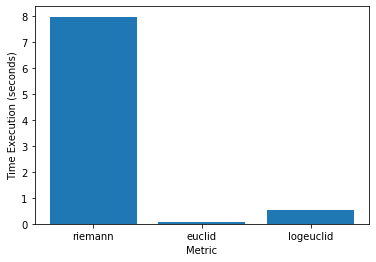

In [16]:
x = np.arange(len(metrics))
 
plt.bar(x, time_execution)
plt.xticks(x, metrics)
plt.xlabel("Metric")
plt.ylabel("Time Execution (seconds)")
plt.show()


The results show that the euclid metric is the fastest,
followed by the logeuclid metric,
and the riemann metric is much slow.